# Numerical Results for the Gene Expression Network

### Compare Gillespie simulation with mass action kinetics and Plefka approximation

In [1]:
using Pkg
cd(@__DIR__)
Pkg.activate("../../")
using CRN
using PyPlot
PyPlot.PyDict(PyPlot.matplotlib."rcParams")["font.size"] = 16

 Activating environment at `~/ownCloud/Master/Simulations/CRN/Project.toml`


16

In [64]:
# Parameters
num_species = 3     # number of species
num_int = 3         # number of interaction reaction

# Reaction constants
k1 = 0*[8.0, 8.0, 3.0]    # Creation
k2 = [0, 2.0, 0]    # Annihiliation
#k2[2] = 1.0   # keep annihilation of protein unchanged
k3 = [0.3, 1.6, 0.3]           # Interaction
k = [k1, k2, k3]

# Stoichiometric
s_i = zeros(Int, num_int, num_species)
r_i = copy(s_i)
s_i[1,:] = [1 1 0]
r_i[1,:] = [1 0 0]
s_i[2,:] = [0 0 1]
r_i[2,:] = [1 1 0]
s_i[3,:] = [1 1 0]
r_i[3,:] = [0 0 1]

# Times
t_init = 0.0        # Start time
t_final = 10.0       # End time
delta_t = 0.02      # time step
tspan = collect(t_init:delta_t:t_final)

# Initial condition
# x0 = k1 ./ k2
x0 = [3., 1., 2.]

3-element Array{Float64,1}:
 3.0
 1.0
 2.0

## Gillespie Simulation

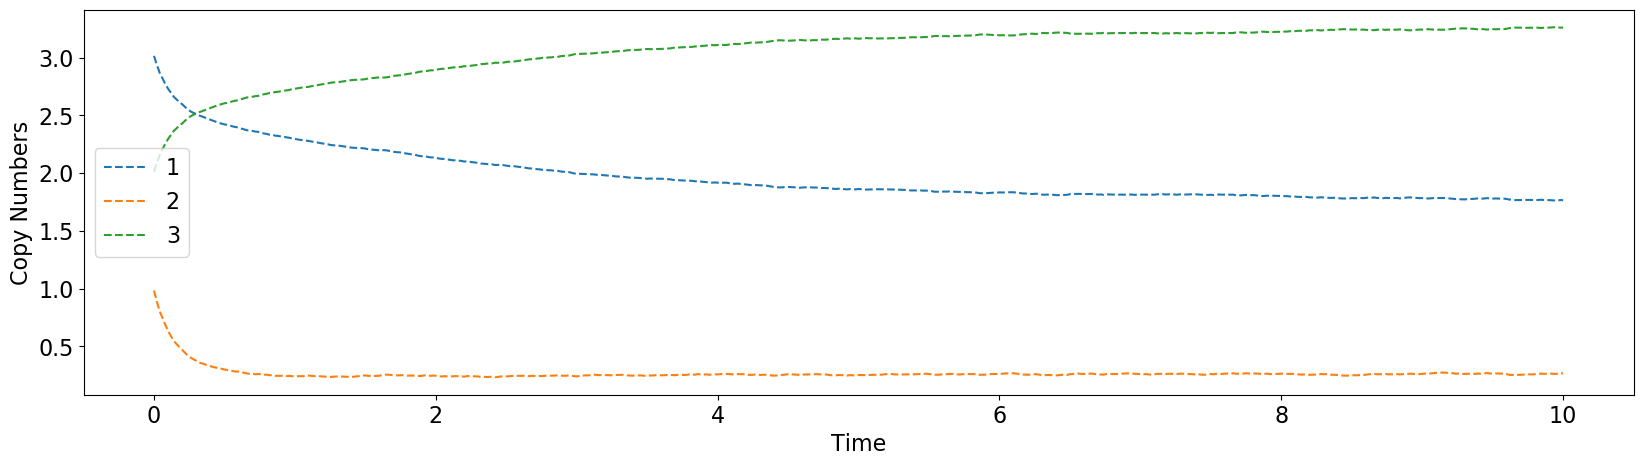

PyObject Text(32.999999999999986, 0.5, 'Copy Numbers')

In [65]:
N = 10000   # Repititions
res_gil = gillespie_avg(x0, k, s_i, r_i, tspan, N)
plot_trajectories(res_gil)

## Mass Action Kinetics

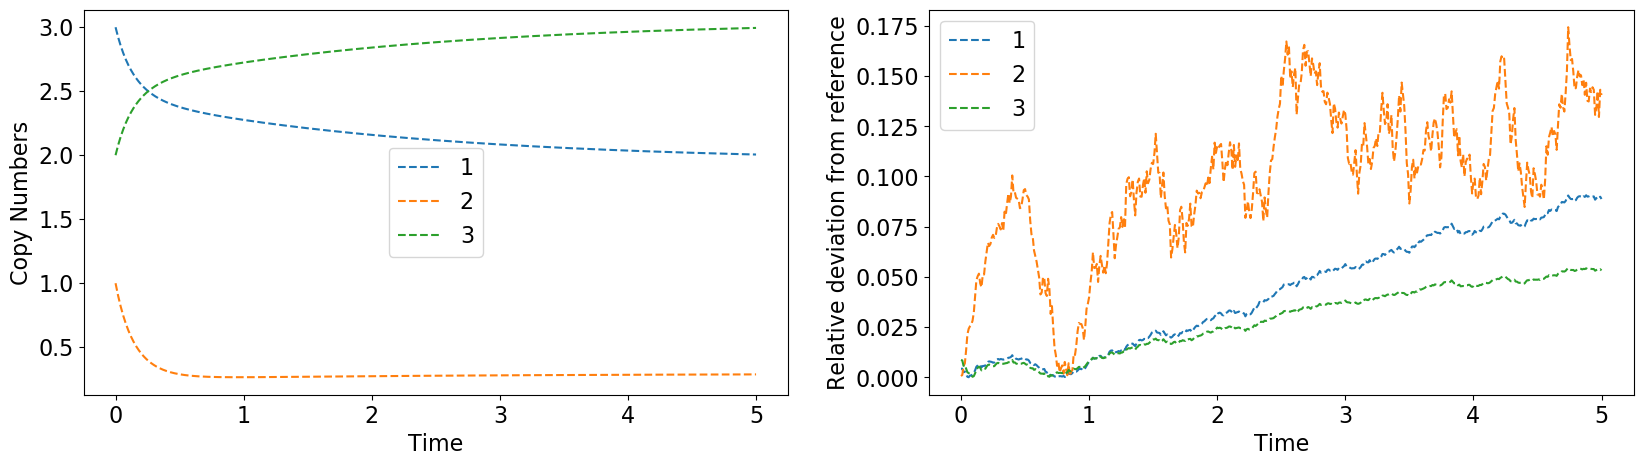

PyObject Text(850.2045454545454, 0.5, 'Relative deviation from reference')

In [62]:
function f_massAction!(du,u,k,t)
    du[1] = k1[1] - k2[1]*u[1] - k3[2]*u[1]*u[2] + k3[3]*u[3]
    du[2] = k1[2] - k2[2]*u[2] + k3[1]*u[1] - k3[2]*u[1]*u[2] + k3[3]*u[3]
    du[3] = k1[3] - k2[3]*u[3] + k3[2]*u[1]*u[2] - k3[3]*u[3]
end

ts = (tspan[1], tspan[end])
res_ma = ode_solver(f_massAction!, k, ts, delta_t, x0)
plot_trajectories_and_deviation(res_ma, res_gil)

## Plefka with linear O.P. and power α¹ 

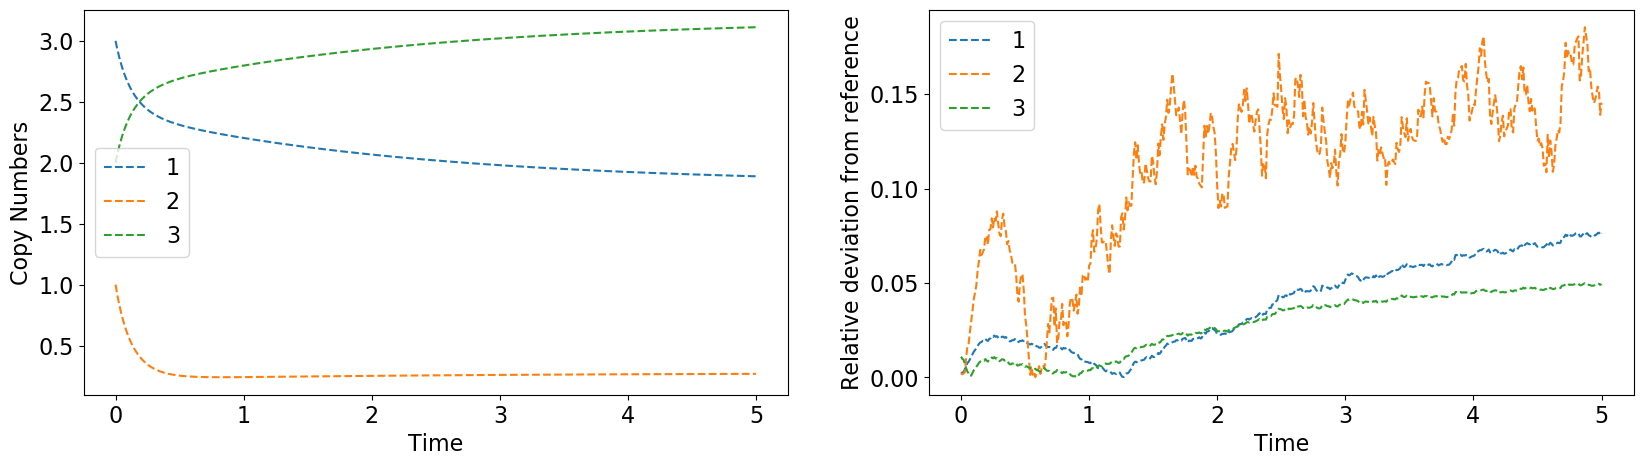

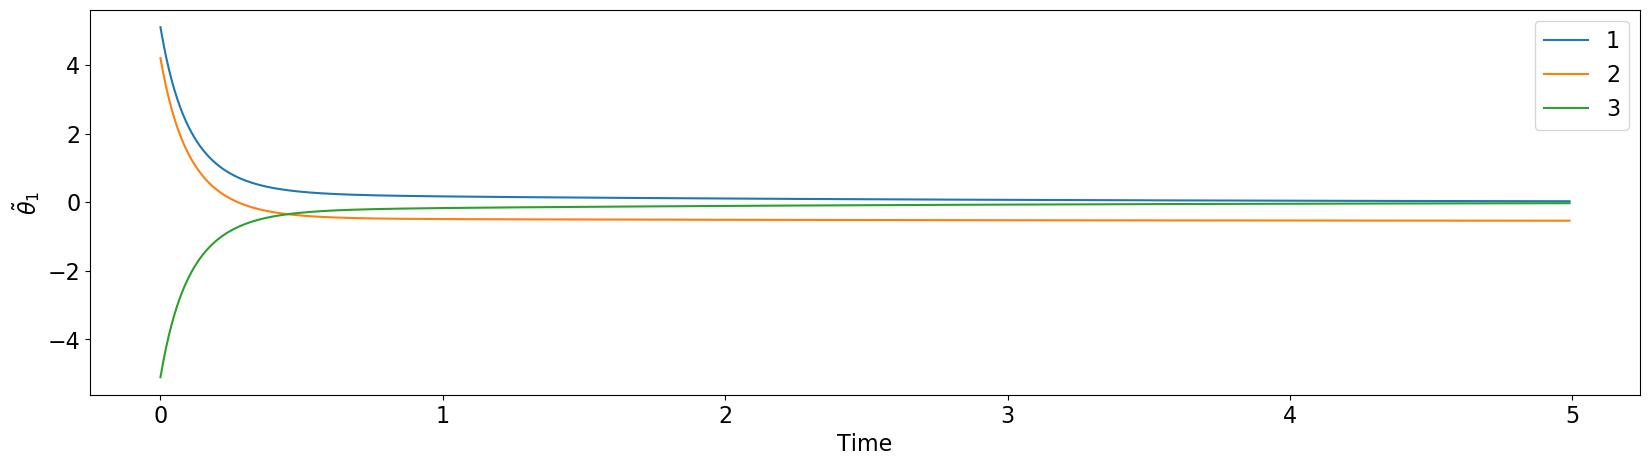

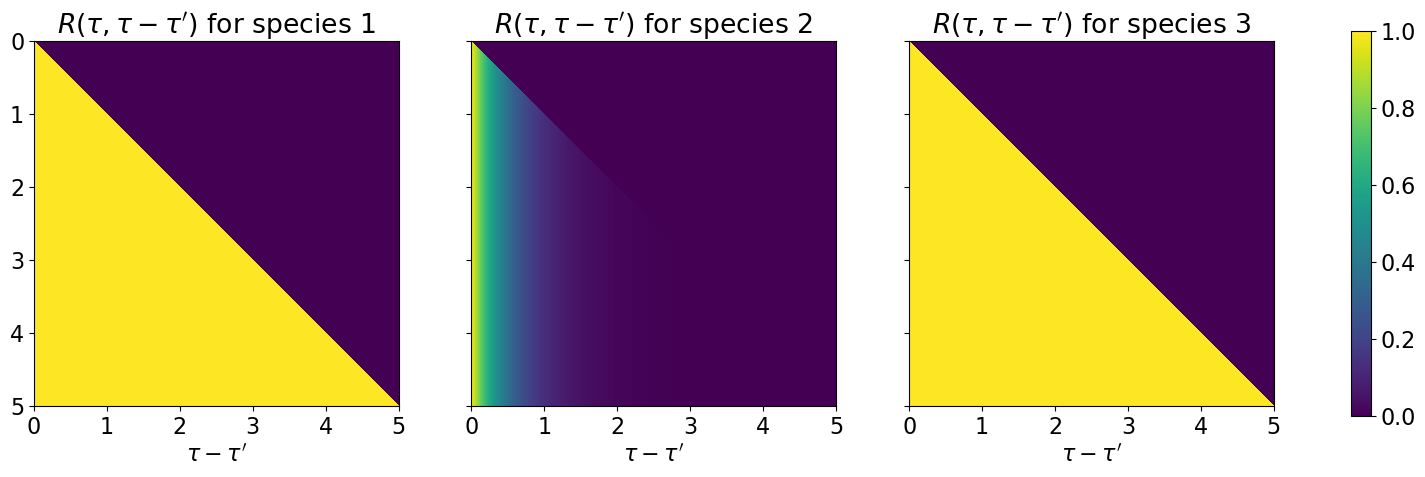

In [58]:
plf_sim_11 = Plefka(1.0, 1, "linear") # α, alphaOrder, orderParameter
res_plf_11 = euler_step(x0, k, tspan, plf_sim_11, s_i, r_i)
plot_trajectories_and_deviation(res_plf_11[1], res_gil)
plot_hatTheta(plf_sim_11, res_plf_11[3])
plot_responses(res_plf_11[2])

## Plefka with linear O.P. and power α²

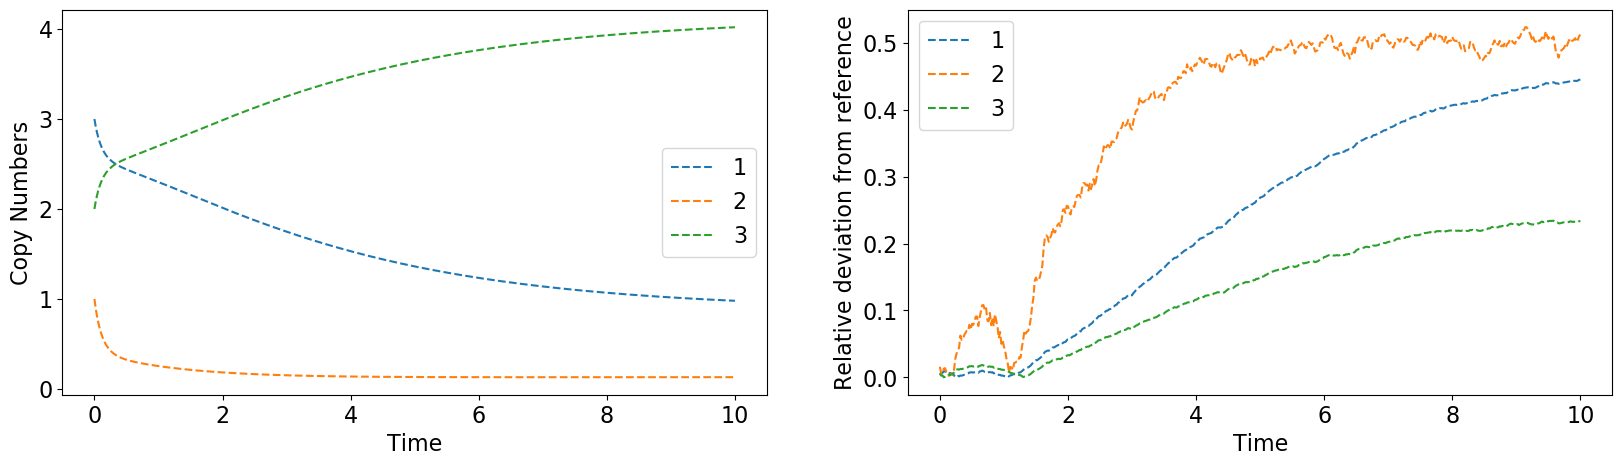

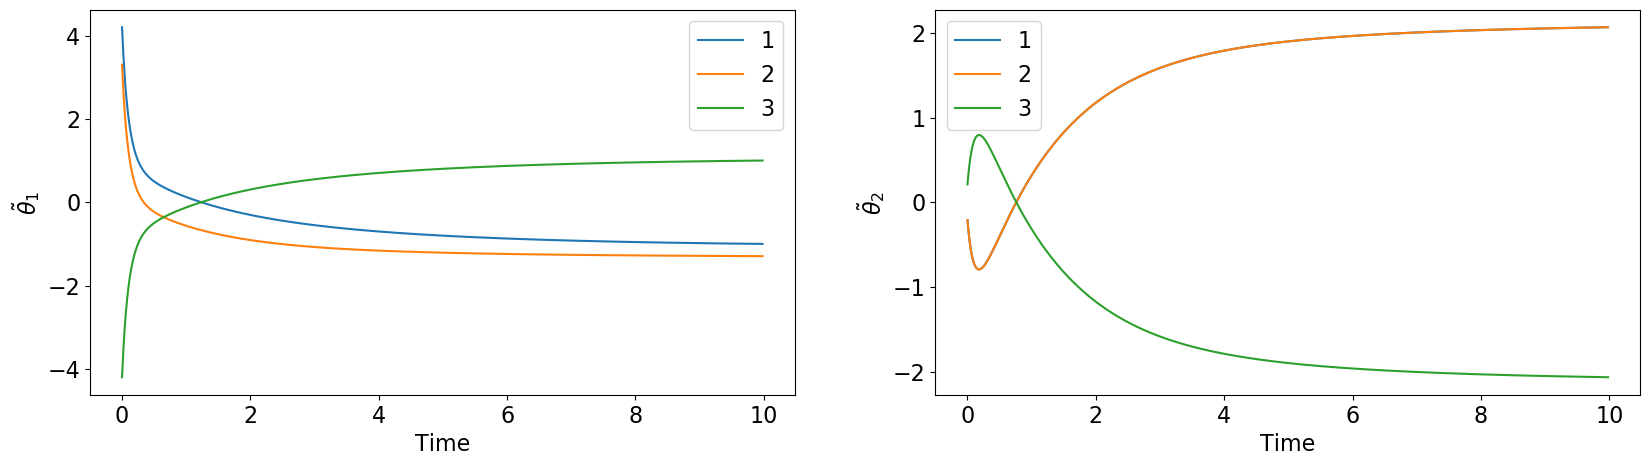

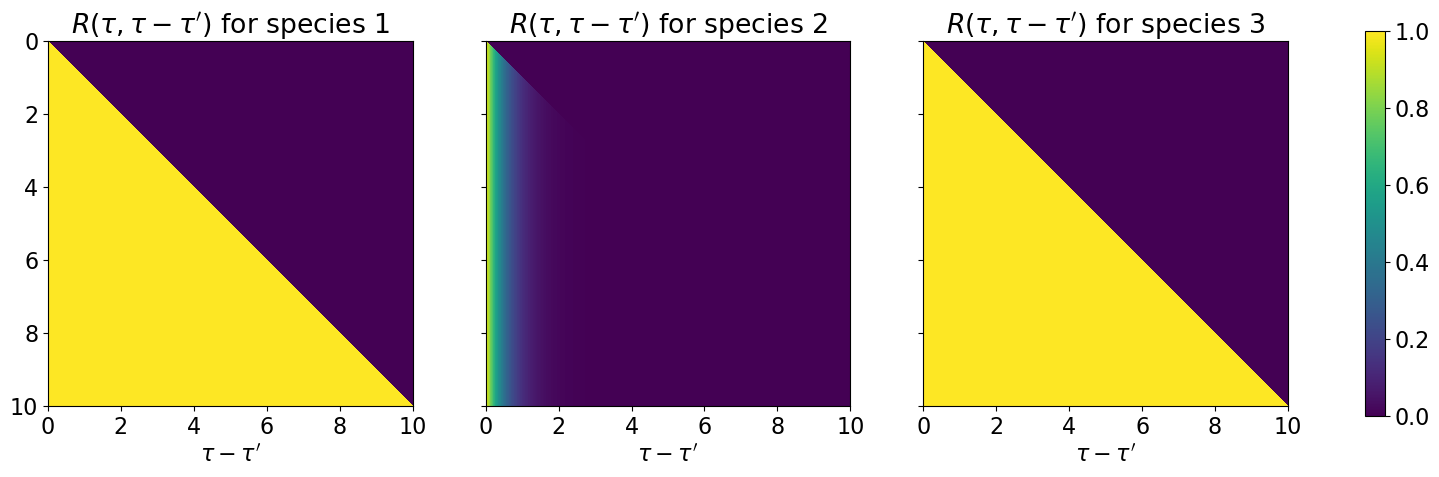

In [66]:
plf_sim_21 = Plefka(1.0, 2, "linear") # α, alphaOrder, orderParameter
res_plf_21 = euler_step(x0, k, tspan, plf_sim_21, s_i, r_i)
plot_trajectories_and_deviation(res_plf_21[1], res_gil)
plot_hatTheta(plf_sim_21, res_plf_21[3])
plot_responses(res_plf_21[2])

## Plefka with quad O.P. and power α¹ 

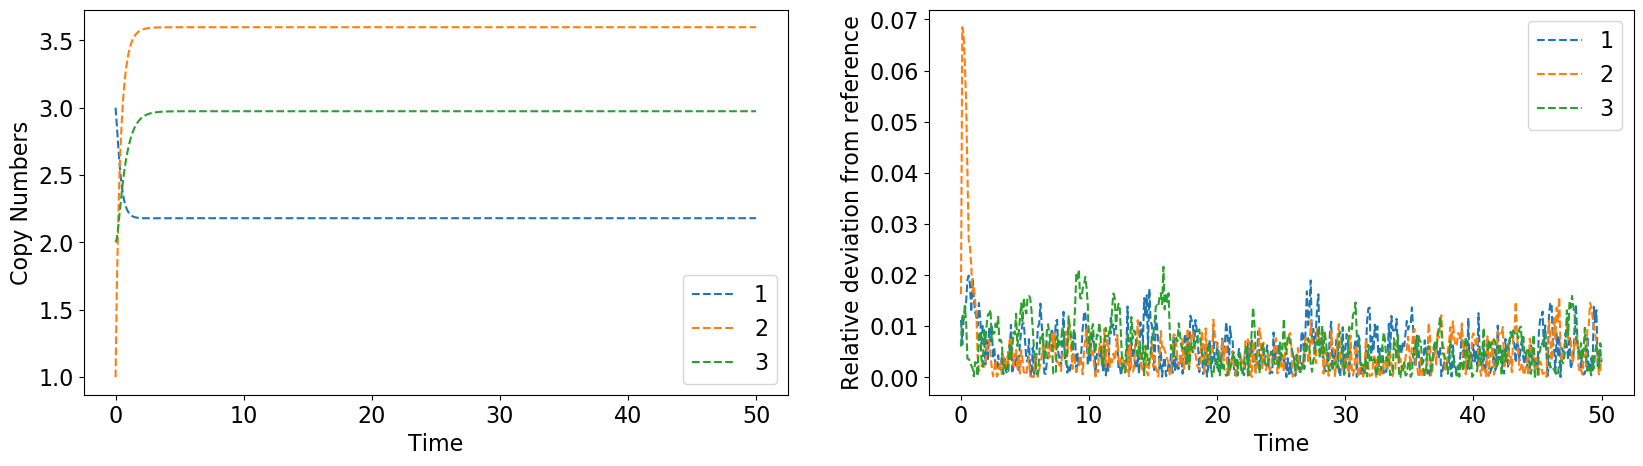

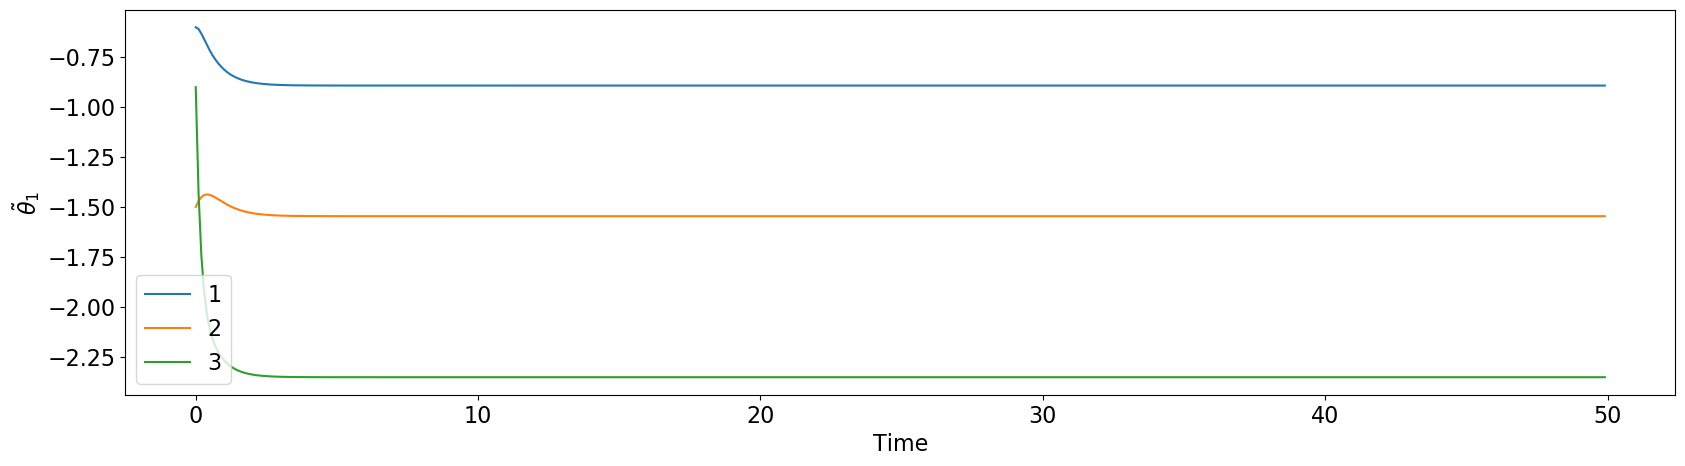

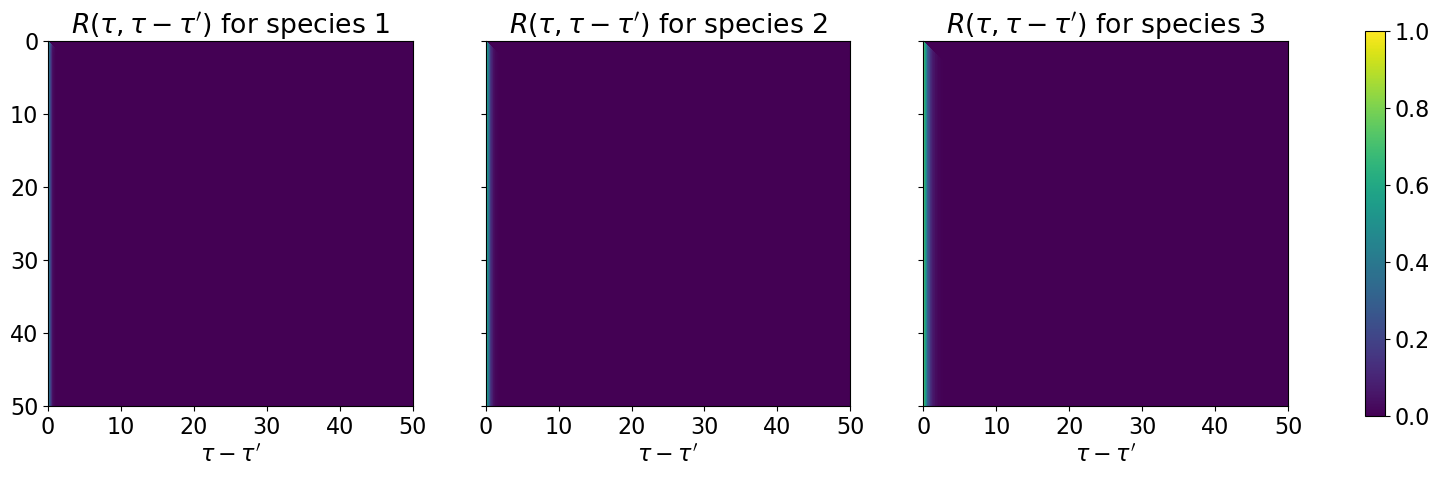

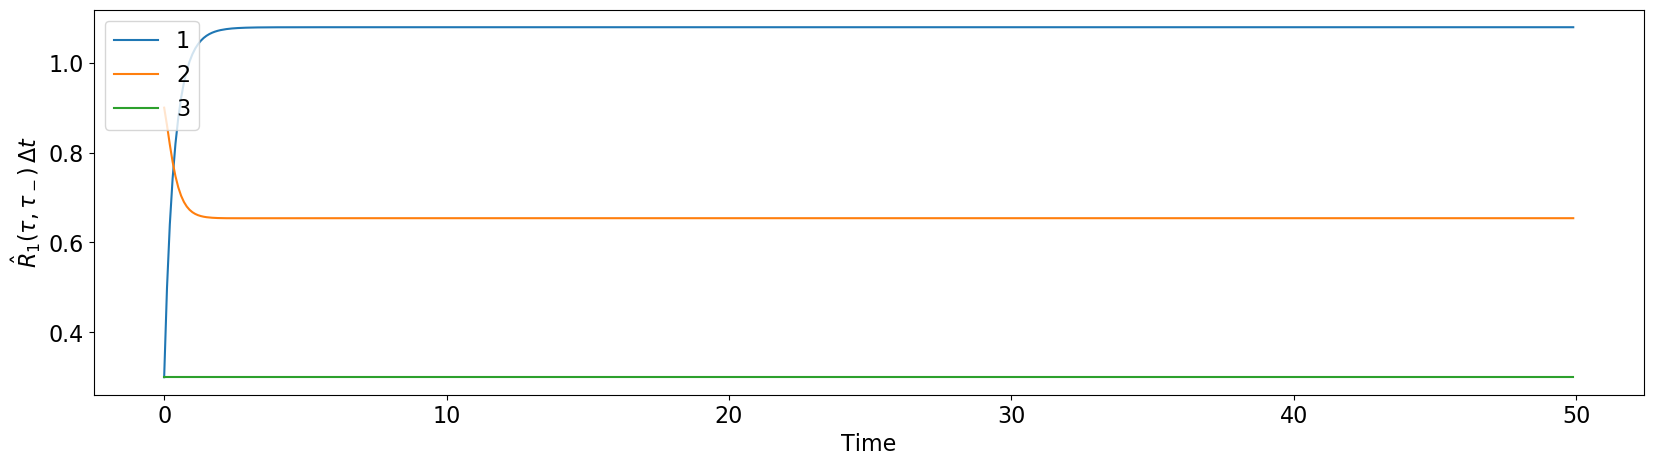

PyObject Text(43.17777777777776, 0.5, '$\\hat{R}_1(\\tau,\\tau_-)\\,\\Delta t$')

In [45]:
plf_sim_12 = Plefka(1.0, 1, "quad") # α, alphaOrder, orderParameter
res_plf_12 = euler_step(x0, k, tspan, plf_sim_12, s_i, r_i)
plot_trajectories_and_deviation(res_plf_12[1], res_gil)
plot_hatTheta(plf_sim_12, res_plf_12[3])
plot_responses(res_plf_12[2])
plot_hatR_diag(tspan, res_plf_12[3].hatR1)

## Plefka with quad O.P. and power α²

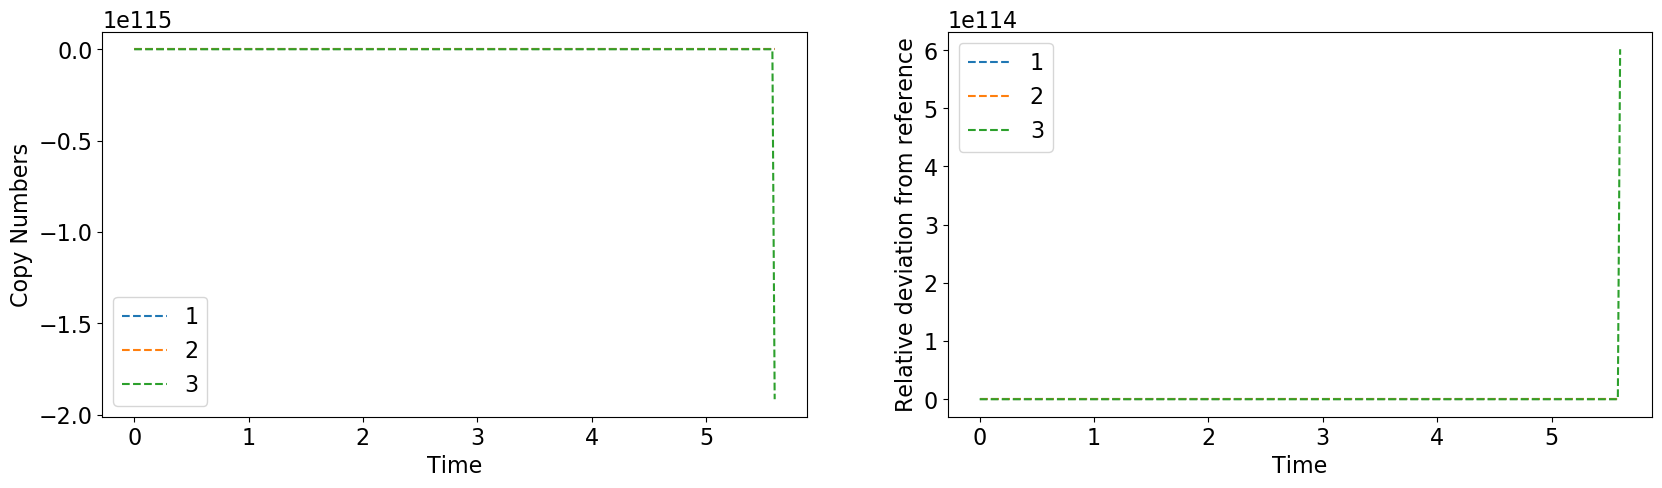

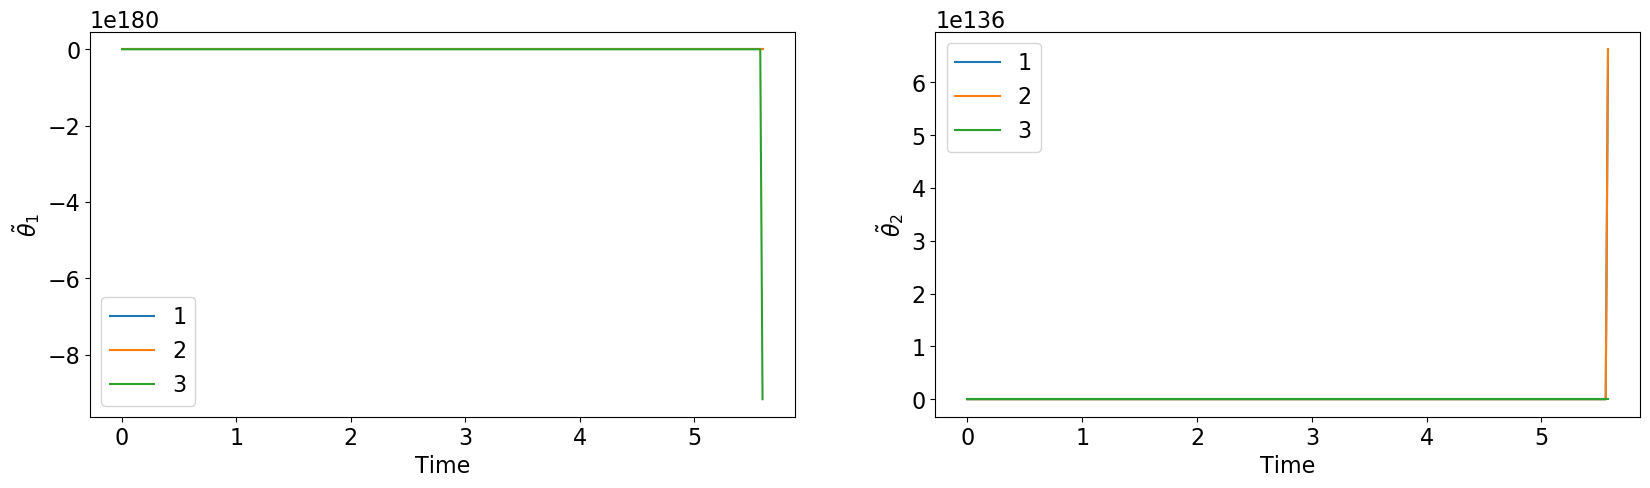

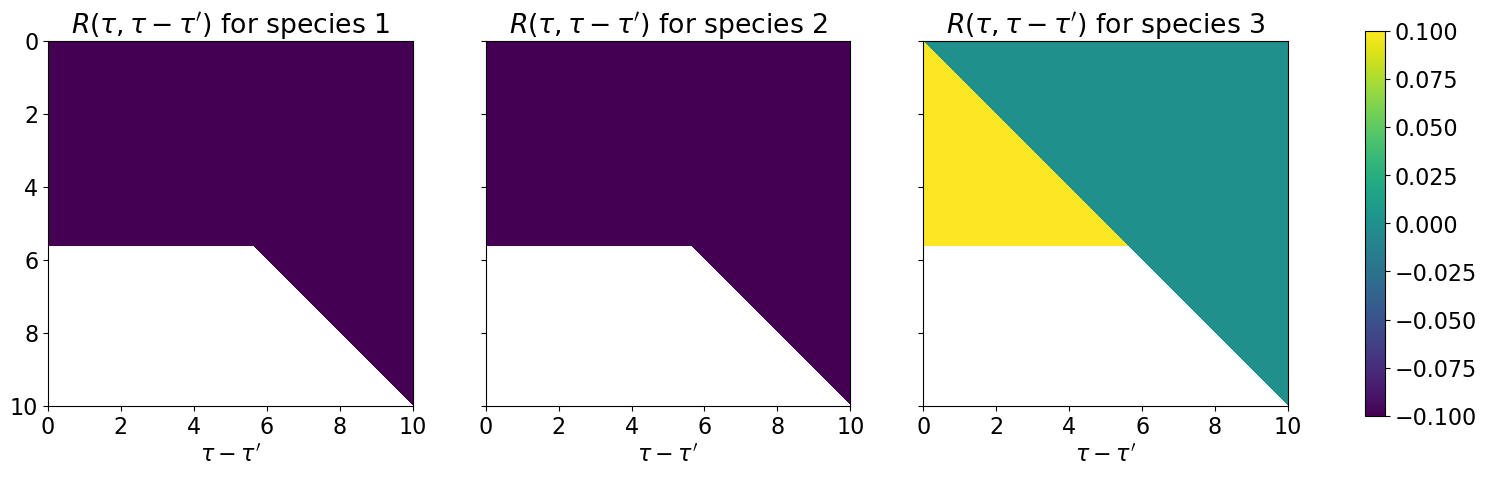

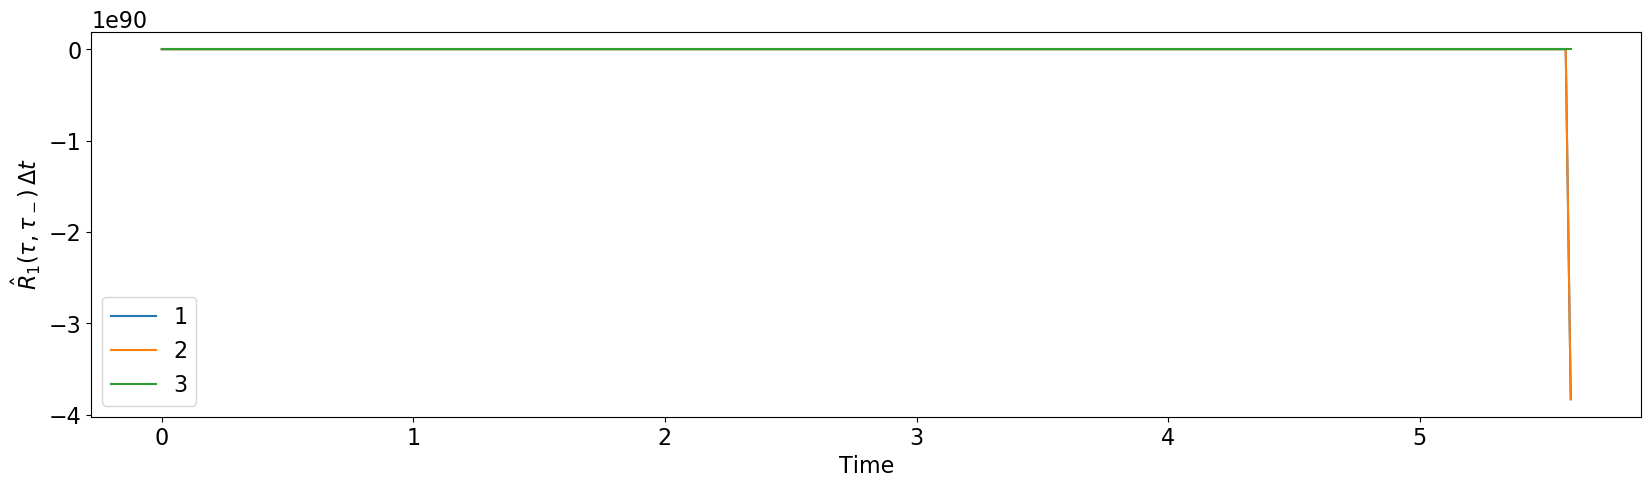

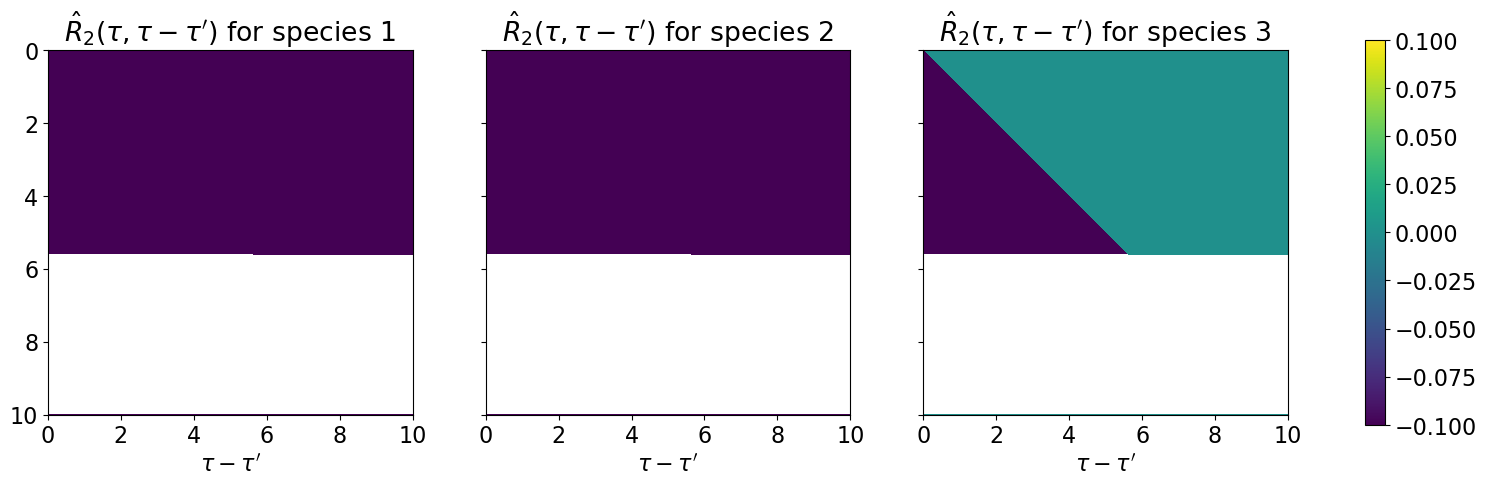

In [67]:
plf_sim_22 = Plefka(1.0, 2, "quad") # α, alphaOrder, orderParameter
res_plf_22 = euler_step(x0, k, tspan, plf_sim_22, s_i, r_i)
plot_trajectories_and_deviation(res_plf_22[1], res_gil)
plot_hatTheta(plf_sim_22, res_plf_22[3])
plot_responses(res_plf_22[2])
plot_hatR_diag(tspan, res_plf_22[3].hatR1)
plot_hatR(tspan, res_plf_22[3].hatR2, quadR=true)

In [73]:
#plot_responses_timeslice(res_plf_22[2], 4)
resp = res_plf_22[2].data
hatR1 = res_plf_22[3].hatR1
hatR2 = res_plf_22[3].hatR2
t_i = 1
for k in t_i:-1:1
    x = delta_t^2*sum((hatR1[:,t_i+1,:].*resp[:,:,k])[:,k:t_i], dims=2)
    xx = 0.5*delta_t^2*sum((hatR2[:,t_i,:].*resp[:,:,k])[:,k:t_i], dims=2)
    println((1 .- k2*delta_t).*resp[:,t_i,k] .- x .- xx)
end
sum(res_plf_21[1].data[1,:] .* res_plf_21[3].hatR1[1,1,:])


[0.9715199999999999; 0.870144; 0.99496]


0.0

In [9]:
using LinearAlgebra
plf_sim_22 = Plefka(1.0, 2, "quad")
len_ts = length(tspan)
dt = tspan[2] - tspan[1]

# Initialize trajectory
y = zeros(num_species, len_ts)
y[:,1] = x0

# Initialize response functions
resp = zeros(num_species, len_ts, len_ts)
for i in 1:num_species
    resp[i,:,:] = Matrix{Int}(I, len_ts, len_ts)
end

# Initialize fields (even if we don't need them)
hatTheta1 = zeros(num_species, len_ts)
hatTheta2 = copy(hatTheta1)
hatR1 = zeros(num_species, len_ts, len_ts)
hatR2 = copy(hatR1)
fields = Fields(tspan, hatTheta1, hatTheta2, hatR1, hatR2);

In [10]:
include("../../testing/euler_step.jl")

y_derivative

In [ ]:
for i in 1:2000
    update_fields(plf_sim_22, s_i, r_i, k[3], i, dt, y, resp, fields)
    update_responses(plf_sim_22, resp, k, dt, i, fields.hatR1, fields.hatR2)
    dydt = y_derivative(plf_sim_22, y, k, i, dt, fields)
    y[:,i+1] = y[:,i] + dt.*dydt
end

In [193]:
i = 190
update_fields(plf_sim_22, s_i, r_i, k[3], i, dt, y, resp, fields)
fields.hatTheta1[:,i-3:i+3]

3×7 Array{Float64,2}:
 -2.71141   -3.02801     -3.36225    …  -3.88968   -3.85516   -3.32194
 -3.42514   -2.99489     -2.55093       -1.89335   -1.99353   -2.7891
 -0.220864   0.00480924  -0.0263403     -0.656409  -0.614804  -0.0418669

In [194]:
update_responses(plf_sim_22, resp, k, dt, i, fields.hatR1, fields.hatR2)
resp[:,i,i-6:i]

3×7 Array{Float64,2}:
 0.6527    0.719596  0.790828  0.861361  0.924369  0.972497  1.0
 0.449955  0.535384  0.630603  0.730851  0.829873  0.921173  1.0
 0.713829  0.744526  0.781536  0.825544  0.876862  0.935291  1.0

In [195]:
dydt = y_derivative(plf_sim_22, y, k, i, dt, fields)
y[:,i+1] = y[:,i] + dt.*dydt

3×1 Array{Float64,2}:
 -1.6636068405901303
 -1.3152335291704116
  7.779350441956827

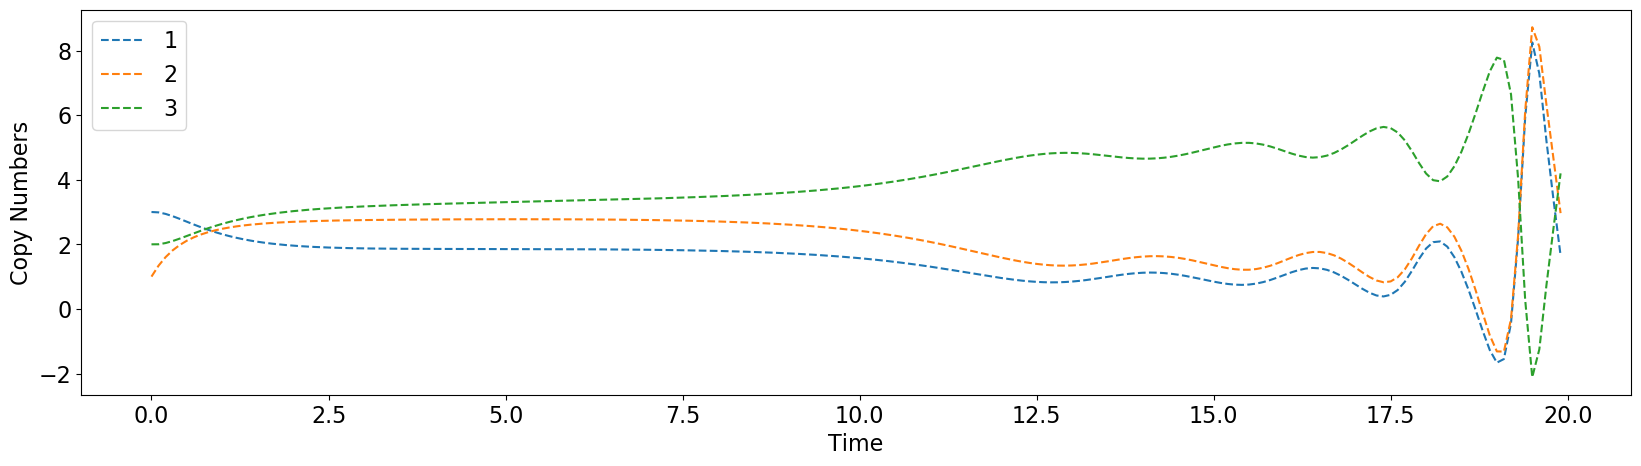

3×1 Array{Float64,2}:
  -3.273678133404508
  -3.176944550561764
 102.68027340808345

In [197]:
res = Result(tspan[1:200], y[:,1:200])
plot_trajectories(res)
sum((hatR1[:,i,:].*resp[:,:,1]), dims=2)

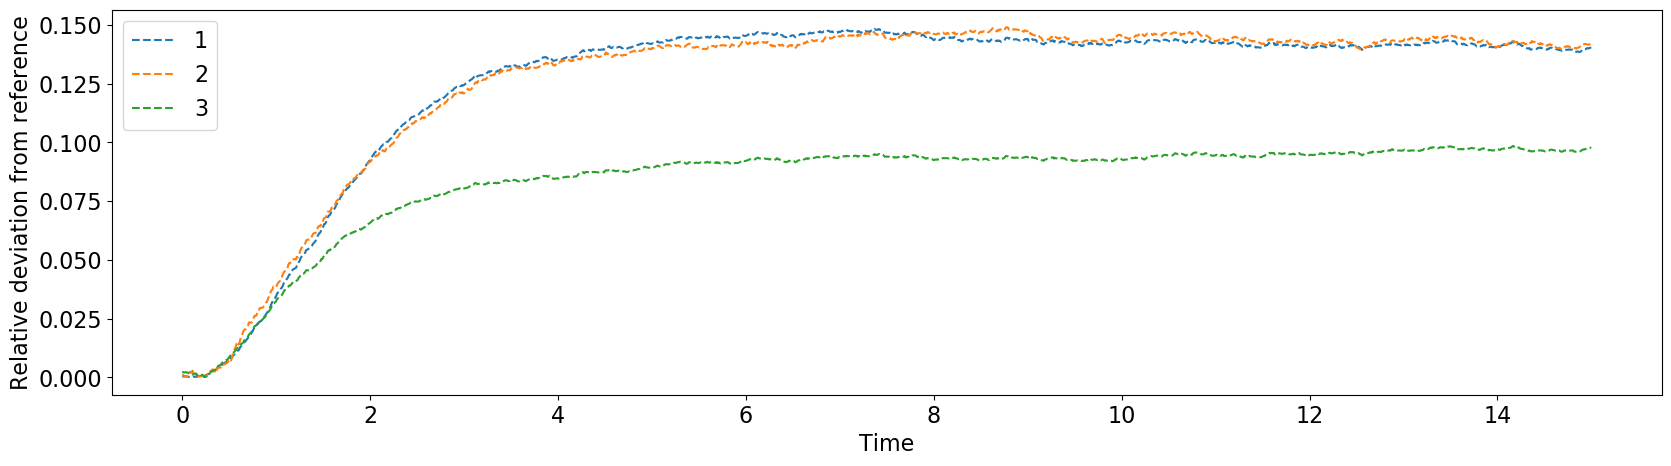

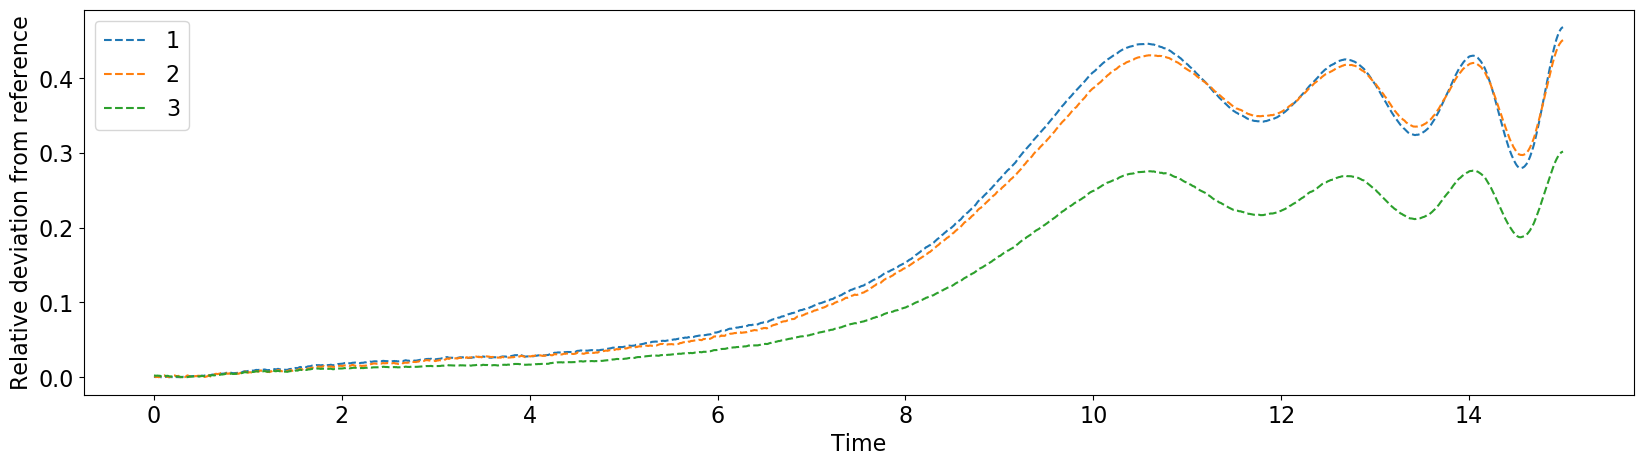

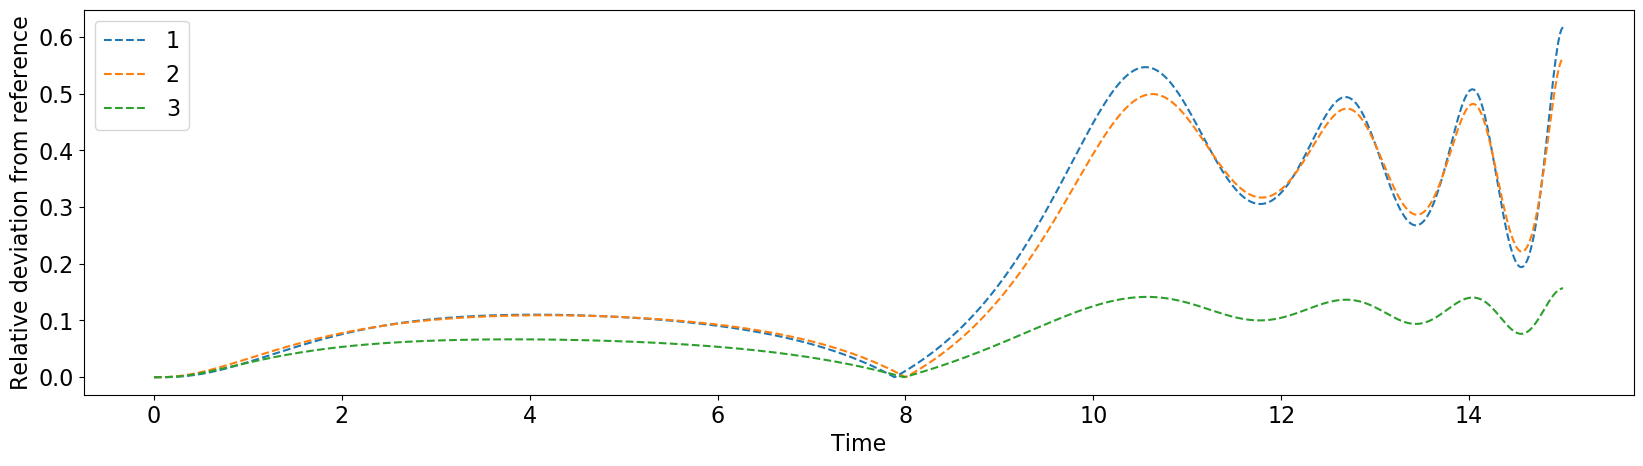

PyObject Text(32.999999999999986, 0.5, 'Relative deviation from reference')

In [10]:
plot_deviation(res_plf_21[1], res_gil)
plot_deviation(res_plf_22[1], res_gil)
plot_deviation(res_plf_21[1], res_plf_22[1])

In [11]:
res_plf_22[2].data

3×1501×1501 Array{Float64,3}:
[:, :, 1] =
 1.0  0.996607  0.993053  0.989345  …  18.2589    18.335     18.4114
 1.0  0.980991  0.962333  0.944021      0.540727   0.536814   0.532636
 1.0  0.994925  0.98995   0.985075     33.6077    33.6841    33.7606

[:, :, 2] =
 0.0  1.0  0.996525  0.992894  0.989112  …  18.305     18.3814    18.458
 0.0  1.0  0.980989  0.962332  0.944022      0.519139   0.515123   0.510843
 0.0  1.0  0.994925  0.989952  0.985077     33.4626    33.5387    33.6147

[:, :, 3] =
 0.0  0.0  1.0  0.996446  0.992738  …  18.3468    18.4235    18.5003
 0.0  0.0  1.0  0.980989  0.962332      0.498167   0.494053   0.489676
 0.0  0.0  1.0  0.994926  0.989953     33.3176    33.3933    33.4689

...

[:, :, 1499] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  0.995806  0.991608
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.986963  0.974101
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.9949    0.989874

[:, :, 1500] =
 0.0  0.0  0.0  0.0 